In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [8]:
data = pd.read_csv(r"Electric_Production.csv")

In [9]:
data.head()

,DATE,IPG2211A2N
0,1939-01-01,3.3842
1,1939-02-01,3.4100
2,1939-03-01,3.4875
3,1939-04-01,3.5133
4,1939-05-01,3.5133


In [10]:
data.isnull().sum()

DATE          0
IPG2211A2N    0
dtype: int64

In [11]:
data.columns=['Date', 'IPG2211A2N']
data=data.dropna()
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True) #set date as index
data.head()

,IPG2211A2N
Date,
1939-01-01,3.3842
1939-02-01,3.4100
1939-03-01,3.4875
1939-04-01,3.5133
1939-05-01,3.5133


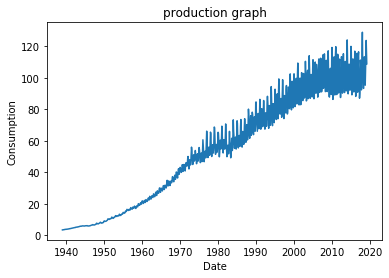

In [12]:
#Visualizing time series
plt.xlabel("Date")
plt.ylabel("Consumption")
plt.title("production graph")
plt.plot(data)

In [13]:
#The above series mean is not constant and this series is not stationary.

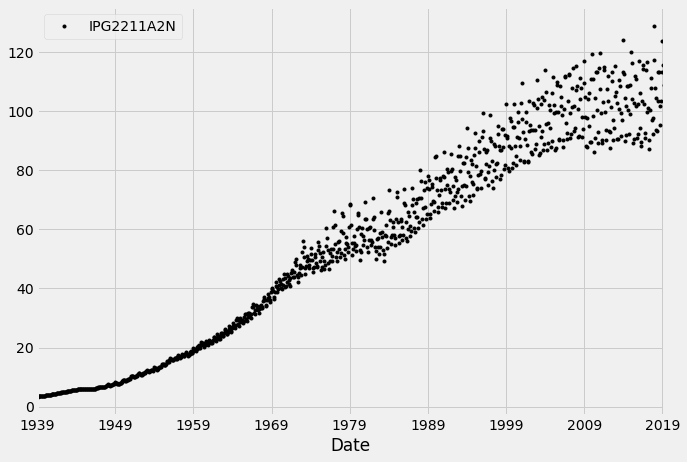

In [12]:
data.plot(style='k.')
plt.show()

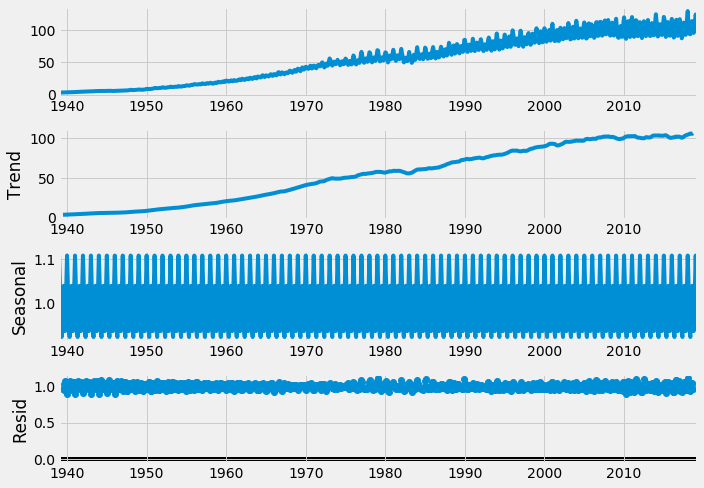

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data, model='multiplicative')
result.plot()
plt.show()

In [2]:
#Null Hypothesis: The series has a unit root (value of a =1)
#Alternate Hypothesis: The series has no unit root.
#The series is linear
#The upward trend shows that consumption is maximum every year

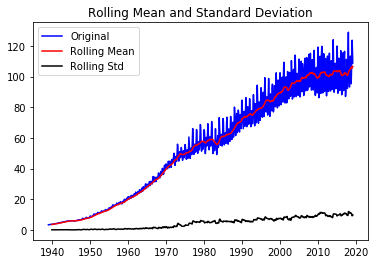

Results of dickey fuller test
Test Statistics                 -0.047060
p-value                          0.954463
No. of lags used                22.000000
Number of observations used    940.000000
critical value (1%)             -3.437326
critical value (5%)             -2.864620
critical value (10%)            -2.568410
dtype: float64


In [22]:
#Stationarising the time series using ADF test

from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    #Determing rolling statistics
    rollmean = timeseries.rolling(12).mean()
    rollstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rollmean, color='red', label='Rolling Mean')
    plt.plot(rollstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries['IPG2211A2N'],autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(data)

In [23]:
#Upon checking still mean and standard deviation are increasing hence series is not stationary
# P-value is greater than 0.05 so we cannot reject the Null hypothesis. The test statistics is greater than the critical values. So the data is not stationary
#To get a stationary series, we need to eliminate trend and seasonality from the series.

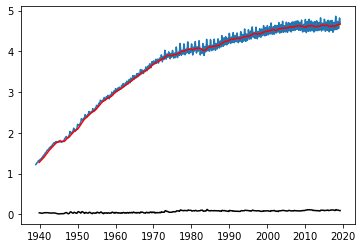

In [24]:
data_log = np.log(data)
moving_avg = data_log.rolling(12).mean()
std_dev = data_log.rolling(12).std()
plt.plot(data_log)
plt.plot(moving_avg, color="red")
plt.plot(std_dev, color ="black")
plt.show()

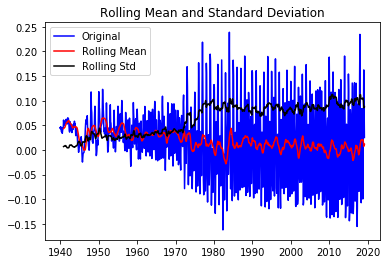

Results of dickey fuller test
Test Statistics                 -3.290595
p-value                          0.015304
No. of lags used                22.000000
Number of observations used    929.000000
critical value (1%)             -3.437409
critical value (5%)             -2.864656
critical value (10%)            -2.568429
dtype: float64


In [26]:
#To obtain a more stationary series
data_log_moving_avg_diff = data_log-moving_avg
data_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(data_log_moving_avg_diff)

In [27]:
#Again performed ADF Test in order to get stationary series. Observed from above graph shows data is stationary 
#the test statistics and critical value is relatively equal.
#High seasonality in the data.

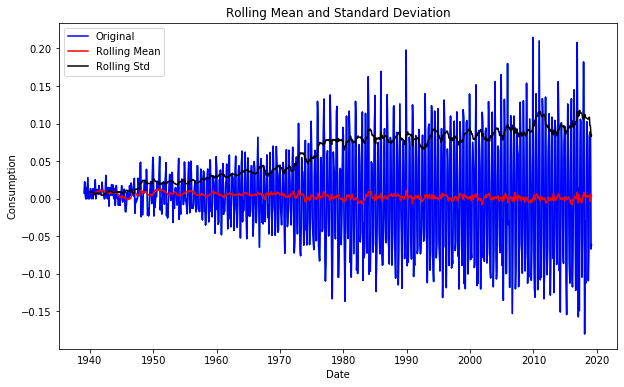

Results of dickey fuller test
Test Statistics                 -5.414763
p-value                          0.000003
No. of lags used                22.000000
Number of observations used    939.000000
critical value (1%)             -3.437333
critical value (5%)             -2.864623
critical value (10%)            -2.568412
dtype: float64


In [36]:
data_log_diff = data_log - data_log.shift()
plt.title("Shifted timeseries")
plt.xlabel("Date")
plt.ylabel("Consumption")
plt.plot(data_log_diff)#Let us test the stationarity of our resultant series
data_log_diff.dropna(inplace=True)
test_stationarity(data_log_diff)


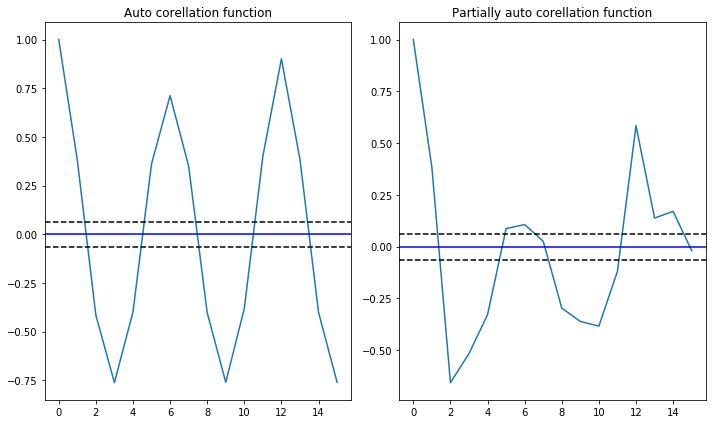

In [37]:
from statsmodels.tsa.stattools import acf,pacf
# we use d value here(data_log_shift)
acf = acf(data_log_diff, nlags=15)
pacf= pacf(data_log_diff, nlags=15,method='ols')#plot PACF
plt.subplot(121)
plt.plot(acf) 
plt.axhline(y=0,linestyle='-',color='blue')
plt.axhline(y=-1.96/np.sqrt(len(data_log_diff)),linestyle='--',color='black')
plt.axhline(y=1.96/np.sqrt(len(data_log_diff)),linestyle='--',color='black')
plt.title('Auto corellation function')
plt.tight_layout()#plot ACF
plt.subplot(122)
plt.plot(pacf) 
plt.axhline(y=0,linestyle='-',color='blue')
plt.axhline(y=-1.96/np.sqrt(len(data_log_diff)),linestyle='--',color='black')
plt.axhline(y=1.96/np.sqrt(len(data_log_diff)),linestyle='--',color='black')
plt.title('Partially auto corellation function')
plt.tight_layout()

RSS : 0.905966


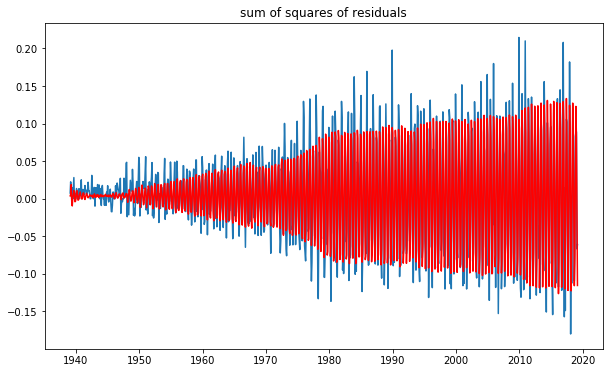

In [39]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(data_log, order=(3,1,3))
result_AR = model.fit(disp = 0)
plt.plot(data_log_diff)
plt.plot(result_AR.fittedvalues, color='red')
plt.title("sum of squares of residuals")
print('RSS : %f' %sum((result_AR.fittedvalues-data_log_diff["IPG2211A2N"])**2))

In [ ]:
#Less the RSS value, the more effective the model is. 

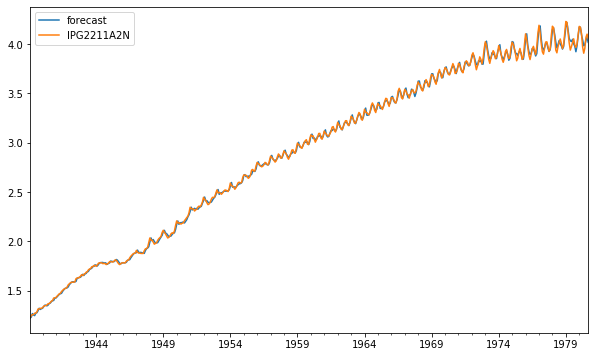

In [47]:
#Predictions
result_AR.plot_predict(1,500)
x=result_AR.forecast(steps=200)